<a href="https://colab.research.google.com/github/fuerdagegen/retail-sales-forecasting/blob/main/model_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

This notebook uses SARIMAX (seasonal ARIMA with exogenous regressors) on a single store–item time series.  
Unlike tree-based models, ARIMA-family models are fit per series and require model-order selection and diagnostics.  
Running SARIMAX across every store–item pair would be computationally expensive and difficult to tune reproducibly in Colab, so this notebook demonstrates the approach on one representative series.

In [ ]:
# Install statsmodels in the Colab environment
!pip install statsmodels

# Core libraries
import numpy as np
import pandas as pd

# Plotting
from matplotlib import pyplot as plt

# Time-series models and diagnostics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Google Drive integration
from google.colab import drive

# Loading the data

The cleaned dataset is loaded from Drive.  
A single store–item pair is then selected and converted into a chronological daily series for SARIMAX.

In [ ]:
# Load the cleaned dataset from Drive
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/retail-sales-forecasting/df_train_sample.csv')

Mounted at /content/drive


In [ ]:
# Select a single store–item pair for a univariate SARIMAX model
store = 34
item = 103501
df_pair = df_train[(df_train.store_nbr == store) & (df_train.item_nbr == item)].copy()

df_pair.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
6825,34,103501,2013-01-02,5.0,False,2013,1,2,2,5.000000
6826,34,103501,2013-01-03,0.0,False,2013,1,3,3,2.500000
6827,34,103501,2013-01-04,0.0,False,2013,1,4,4,1.666667
6828,34,103501,2013-01-05,0.0,False,2013,1,5,5,1.250000
6829,34,103501,2013-01-06,0.0,False,2013,1,6,6,1.000000


In [ ]:
# Prepare time index and sort chronologically
df_pair['date'] = pd.to_datetime(df_pair['date'])
df_pair = df_pair.sort_values('date').set_index('date')

In [ ]:
# Train-test split aligned with the project forecasting horizon
train = df_pair.loc[:'2013-12-31']
test = df_pair.loc['2014-01-01':'2014-03-31']

y_train = train['unit_sales']
y_test = test['unit_sales']

exog_train = train[['onpromotion', 'unit_sales_7d_avg']]
exog_test = test[['onpromotion', 'unit_sales_7d_avg']]

In [ ]:
# Convert boolean exogenous variables to numeric for SARIMAX
exog_train_numeric = exog_train.copy()
exog_test_numeric = exog_test.copy()

exog_train_numeric['onpromotion'] = exog_train_numeric['onpromotion'].astype(int)
exog_test_numeric['onpromotion'] = exog_test_numeric['onpromotion'].astype(int)

# SARIMAX model

A SARIMAX model is fit with weekly seasonality (`seasonal_order=(..., 7)`), using promotion and rolling average as exogenous regressors.  
The parameters here are a baseline configuration and can be tuned further using ACF/PACF diagnostics or grid search.

In [ ]:
# Scale exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train_numeric)

In [ ]:
# Fit SARIMAX with weekly seasonality and exogenous regressors
model = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=exog_train_scaled,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(
    method='lbfgs',
    maxiter=500,
    disp=False
)

In [ ]:
# Forecast over the test horizon using the aligned exogenous variables
forecast = results.get_forecast(steps=len(test), exog=exog_test_numeric)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

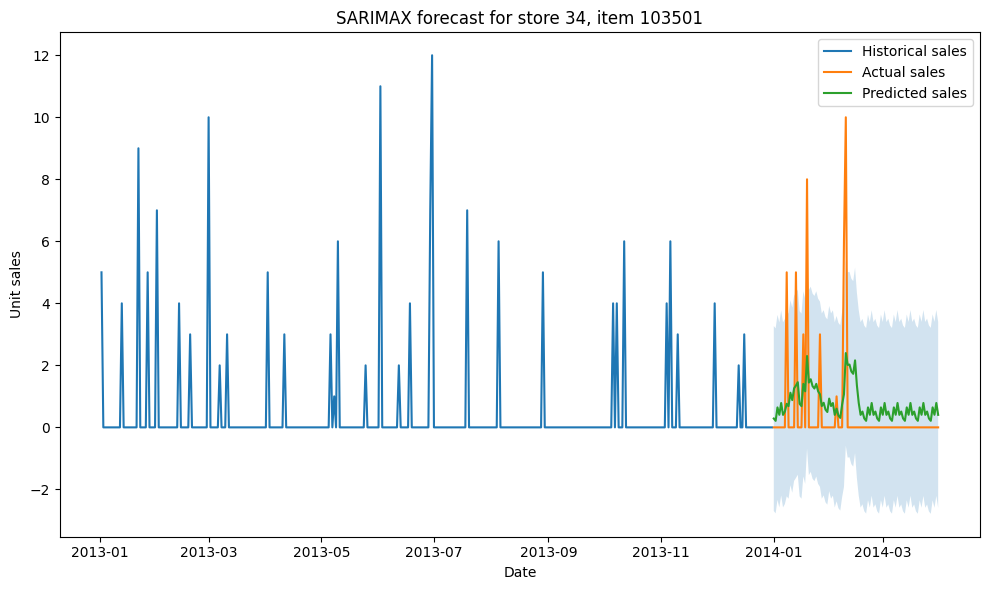

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(y_train.index, y_train, label='Historical sales')
plt.plot(y_test.index, y_test, label='Actual sales')
plt.plot(pred.index, pred, label='Predicted sales')

plt.fill_between(
    pred.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title(f"SARIMAX forecast for store {store}, item {item}")
plt.xlabel("Date")
plt.ylabel("Unit sales")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compute evaluation metrics on the test set
mse = mean_squared_error(y_test, pred)                 # average squared error
rmse = np.sqrt(mse)                                    # error in original units
mae = mean_absolute_error(y_test, pred)                # average absolute error
r2 = r2_score(y_test, pred)                            # 1 = perfect fit

In [ ]:
print("SARIMAX model performance")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"R²:   {r2:.4f}")

SARIMAX model performance
RMSE: 1.5296
MAE:  0.9775
MSE:  2.3396
R²:   0.1588
